In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
# 使用LSTM预测PM 2.5
import tensorflow
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import DataFrame
from pandas import concat
from itertools import chain
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


Using TensorFlow backend.


### 导入数据

In [2]:
# 将原始数据格式中的year, month, day, hour进行合并，并保存新的文件pollution.csv
from pandas import read_csv
from datetime import datetime
# 数据加载
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('./raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
print(dataset.head())
dataset.drop('No', axis=1, inplace=True)
# 列名替换
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# 缺失值填充
dataset['pollution'].fillna(0, inplace=True)
# 去掉第一天数据（前24小时）
dataset = dataset[24:]
# 数据浏览
print(dataset.head(5))
# 数据保存
dataset.to_csv('pollution.csv')


                     No  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
year_month_day_hour                                                   
2010-01-01 00:00:00   1    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2010-01-01 01:00:00   2    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2010-01-01 02:00:00   3    NaN   -21 -11.0  1019.0   NW   6.71   0   0
2010-01-01 03:00:00   4    NaN   -21 -14.0  1019.0   NW   9.84   0   0
2010-01-01 04:00:00   5    NaN   -20 -12.0  1018.0   NW  12.97   0   0
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.

In [4]:
values = dataset.values
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

### 可视化分析

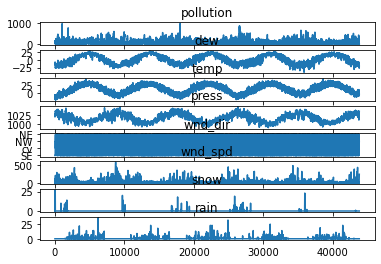

In [5]:
# 一共8个特征
groups = range(8)
for group in groups :
    # 8行，1 列，第n个
    plt.subplot(8,1,group+1)
    # 原始特征values 中的group 列进行可视化
    plt.plot(values[:,group])
    plt.title(dataset.columns[group])
plt.show()

### 类别型转化成数值型

In [6]:
dataset['wnd_dir'].value_counts()

SE    15290
NW    14130
cv     9384
NE     4996
Name: wnd_dir, dtype: int64

In [8]:
# 将分类特征wnd_dir进行标签编码
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# dataset.columns
# Index(['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow','rain'],dtype='object')
# 设置数据类型为float32
values = values.astype('float32')
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

### 数据归一化

In [11]:
# 数据归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled.shape

(43800, 8)

### 数据集格式转换

In [13]:
# 将时间序列数据转换为适合监督学习的数据
"""
将时间序列数据转换为适用于监督学习的数据
给定输入、输出序列的长度
data: 观察序列
n_in: 观测数据input(X)的步长，范围[1, len(data)], 默认为1
n_out: 观测数据output(y)的步长， 范围为[0, len(data)-1], 默认为1
dropnan: 是否删除NaN行
返回值：适用于监督学习的 DataFrame
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接到一起
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
# 将时间序列数据转换为适合监督学习的数据
reframed = series_to_supervised(scaled, 1, 1) # 归一化后的数据,前一时刻预测下一时刻
# print(reframed)
reframed.to_csv('reframed-1.csv')
# # 去掉不需要预测的列，即var2(t)	var3(t)	var4(t)	var5(t)	var6(t)	var7(t)	var8(t)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.to_csv('reframed-2.csv')

### 数据集切分，80% 作为训练集，20% 作为测试集

In [25]:
values = reframed.values
n_train_hours = int(len(values)*0.8)
#前面:n_train_hours 代表前n_train_hours行，后面：代表所有列
train  = values[:n_train_hours,:]
test = values[n_train_hours:,:]
# :-1 表示从0到数组最后一位，-1代表数组最后一位
train_x,train_y = train[:,:-1],train[:,-1]
test_x,test_y = test[:,:-1],test[:,-1]


In [26]:
print(train_x.shape)
print(train_y.shape)  # 仅1列

(35039, 8)
(35039,)


### 转换成LSTM 模型需要的数据格式：3D

In [27]:
# 转换为3D格式[样本数，时间步，特征数]
train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0],1,test_x.shape[1]))

### 建模

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# 设置网络模型
model = Sequential()  # Sequential 序贯模型:可通过将层的列表传递给Sequential的构造函数，来创建一个Sequential模型
## 也可以使用.add()方法将各层添加到模型中：
model.add(LSTM(50,input_shape = (train_x.shape[1],train_x.shape[2])))  #50:50个神经元；[1]：时间步；[2],特征数
## 加上Dense层
model.add(Dense(1)) # 1：1个输出结果
## 训练模型之前，需要配置学习过程，这是通过compile方法完成的;网络的优化器optimizer;回归值，Loss 一般用mse
model.compile(optimizer = 'adam',loss = 'mse')   # 调参 
## 模型训练：迭代次数从10增加到50次
result = model.fit(train_x,train_y,epochs = 50,batch_size = 64,validation_data = (test_x,test_y),verbose = 2,shuffle = False)

Train on 35039 samples, validate on 8760 samples
Epoch 1/50
 - 4s - loss: 0.0040 - val_loss: 0.0069
Epoch 2/50
 - 3s - loss: 0.0013 - val_loss: 0.0054
Epoch 3/50
 - 3s - loss: 9.3962e-04 - val_loss: 0.0039
Epoch 4/50
 - 3s - loss: 8.6224e-04 - val_loss: 0.0032
Epoch 5/50
 - 3s - loss: 8.3064e-04 - val_loss: 0.0028
Epoch 6/50
 - 3s - loss: 8.1504e-04 - val_loss: 0.0026
Epoch 7/50
 - 3s - loss: 8.0640e-04 - val_loss: 0.0024
Epoch 8/50
 - 3s - loss: 8.0077e-04 - val_loss: 0.0023
Epoch 9/50
 - 3s - loss: 7.9652e-04 - val_loss: 0.0021
Epoch 10/50
 - 3s - loss: 7.9318e-04 - val_loss: 0.0020
Epoch 11/50
 - 3s - loss: 7.9057e-04 - val_loss: 0.0019
Epoch 12/50
 - 3s - loss: 7.8854e-04 - val_loss: 0.0018
Epoch 13/50
 - 3s - loss: 7.8695e-04 - val_loss: 0.0017
Epoch 14/50
 - 3s - loss: 7.8570e-04 - val_loss: 0.0016
Epoch 15/50
 - 3s - loss: 7.8469e-04 - val_loss: 0.0016
Epoch 16/50
 - 3s - loss: 7.8386e-04 - val_loss: 0.0015
Epoch 17/50
 - 3s - loss: 7.8317e-04 - val_loss: 0.0015
Epoch 18/50
 - 3

### 模型预测

In [43]:
# 模型预测
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)
test_predict

array([[0.03181575],
       [0.03270813],
       [0.05705197],
       ...,
       [0.01459989],
       [0.01464539],
       [0.01258765]], dtype=float32)

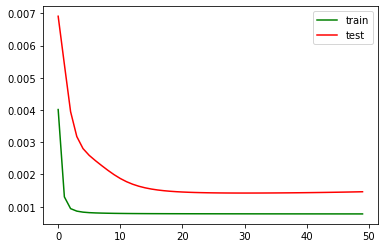

In [44]:
# 绘制训练损失 & 测试损失
line1 = result.history['loss']
line2 = result.history['val_loss']
plt.plot(line1,label = 'train',c = 'g')
plt.plot(line2,label = 'test',c = 'r')
plt.legend(loc = 'best') # 图例 train,test
plt.show()
### 到第7轮开始收敛

In [45]:
model.summary()
# output shape : 神经元50个； Param 参数量 11800

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


### 预测效果

/Users/a1321353523qq.com/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


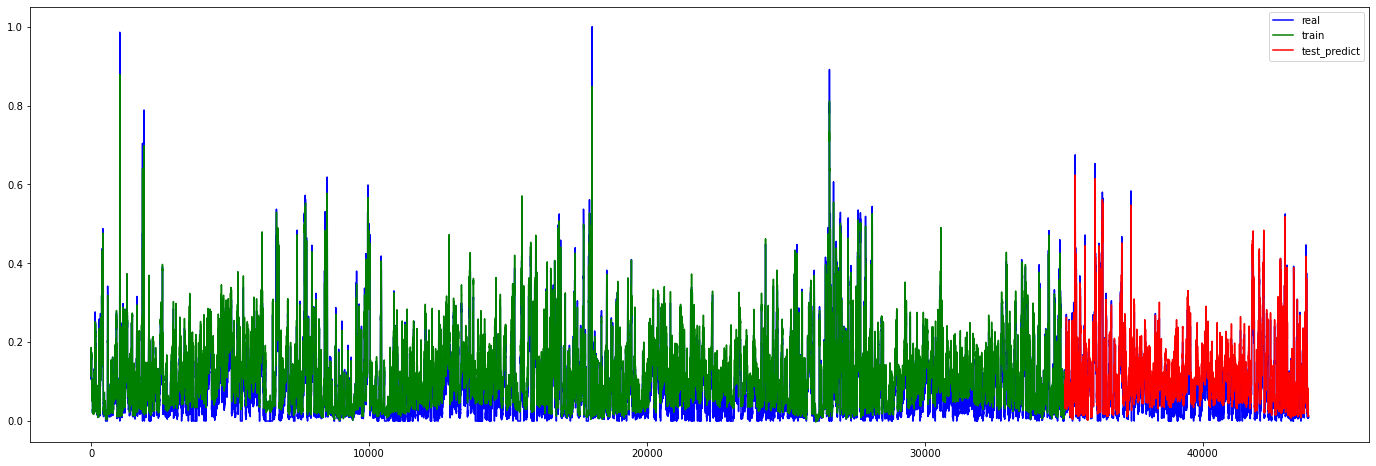

In [46]:
# 呈现原始数据，训练结果，验证结果，预测结果
def plot_img(source_data_set, train_predict,test_predict):
    plt.figure(figsize=(24, 8))
    # 原始数据蓝色
    plt.plot(source_data_set[:, -1], label = 'real',c='b')
    # 训练数据绿色
    plt.plot([x for x in train_predict],label = 'train', c='g')
    # 预测结果红色
    plt.plot([None for _ in train_predict] + [x for x in test_predict],label = 'test_predict',c='r') # NONE 占位
    plt.legend(loc = 'best')
    plt.show()
# 绘制预测结果与实际结果的对比
plot_img(values, train_predict,test_predict)